In [1]:
## IMPORTS
import time, os, sys, healpy
import numpy as np
import multiprocessing as mp
import tqdm
sys.path.append('../')
import polybin as pb
from scipy.interpolate import InterpolatedUnivariateSpline

include_synthetic_b = False

# Binning parameters
dl = 10 # width
Nl = 3#3 # number
min_l = 2 # minimum

# HEALPix settings
Nside = 128
lmax = 3*Nside-1

print("binned lmax: %d,"%(min_l+dl*Nl),"HEALPix lmax: %d"%lmax)

# Whether to include bins only partially satisfying triangle conditions
include_partial_triangles = False

# whether to add a separable reduced bispectrum to the input maps
b_input_fac = lambda l1: np.exp(-(l1-2)/40.)*2e-6

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/projects/QUIJOTE/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

binned lmax: 32, HEALPix lmax: 383


In [2]:
from classy import Class
cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)

# Run CLASS
print("Loading CLASS")
cosmo.set({'output':'tCl,lCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute signal C_ell
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = Cl_dict['tt']*cosmo.T_cmb()**2

# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
thetaFWHM = 5./60.*np.pi/180. # in radians
Nl_th = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>2)

mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)

# Load class with fiducial Cl and Nside
base = pb.PolyBin(Nside, Cl_th+Nl_th)

# Generate unmasked data with known C_l and factorized b
# Cl is set to the fiducial spectrum unless otherwise specified
# No beam is included
print("Generating data")
raw_data = base.generate_data(seed=42, add_B=include_synthetic_b, b_input=b_input_fac)

# Mask the map
data = raw_data*mask

Loading CLASS
## Caution: Zeros detected in input Cl - this may cause problems for inversion!
Generating data


In [3]:
def applySinv(input_map):
    """Apply the optimal weighting to a map. 
    
    Here, we assume that the forward covariance is diagonal, in particular C_l, and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but should be unbiased."""
    
    # Transform to harmonic space
    input_map_lm = base.to_lm(input_map)
    # Divide by covariance and return to map-space
    Cinv_map = base.to_map(base.safe_divide(input_map_lm,base.Cl_lm))
    
    return Cinv_map

In [4]:
# Initialize power spectrum class
tspec = pb.TSpec(base, mask, applySinv, min_l, dl, Nl)

Binning: 3 bins in [2, 32]


In [5]:
def _compute_fisher_ideal(self, parity='even', verb=False, N_cpus=1):
    """
    This computes the idealized Fisher matrix for the trispectrum. If N_cpus > 1, this parallelizes the operation.

    The `parity' parameter can be 'even', 'odd' or 'both'. This specifies what parity trispectra to compute.
    """
    # Check type
    if parity not in ['even','odd','both']:
        raise Exception("Parity parameter not set correctly!")

    # Compute symmetry factors, if not already present
    if not hasattr(self, 'sym_factor_even') and parity!='odd':
        self._compute_even_symmetry_factor()
    if not hasattr(self, 'sym_factor_odd') and parity!='even':
        self._compute_odd_symmetry_factor()

    # Define arrays
    if parity!='even':
        fish_odd = np.zeros((self.N_t_odd, self.N_t_odd))
    if parity!='odd':
        fish_even = np.zeros((self.N_t_even, self.N_t_even))

    if N_cpus==1:
        # Iterate over first set of bins
        # Note that we use two sets of indices here, since there are a different number of odd and even bins
        index1e = -1
        index1o = -1
        for bin1 in range(self.Nl):
            for bin2 in range(bin1,self.Nl_squeeze):
                for bin3 in range(bin1,self.Nl):
                    for bin4 in range(bin3,self.Nl_squeeze):
                        if bin1==bin3 and bin4<bin2: continue
                        if bin1==bin3 and bin2==bin4 and parity=='odd': continue
                        for binL in range(self.Nl_squeeze):
                            # skip bins outside the triangle conditions
                            if not self._check_bin(bin1,bin2,binL,even=False): continue
                            if not self._check_bin(bin3,bin4,binL,even=False): continue

                            # Update indices
                            index1e += 1
                            if ((bin1==bin3)*(bin2==bin4))!=1:
                                index1o += 1 # no equal bins!

                            if verb and parity!='odd':
                                if (index1e+1)%5==0: print("Computing bin %d of %d"%(index1e+1,self.N_t_even))
                            if verb and parity=='odd':
                                if (index1o+1)%5==0: print("Computing bin %d of %d"%(index1o+1,self.N_t_odd))

                            # Iterate over second set of bins
                            index2e = -1
                            index2o = -1
                            for bin1p in range(self.Nl):
                                for bin2p in range(bin1p,self.Nl_squeeze):
                                    for bin3p in range(bin1p,self.Nl):
                                        for bin4p in range(bin3p,self.Nl_squeeze):
                                            if bin1p==bin3p and bin4p<bin2p: continue
                                            if bin1p==bin3p and bin2p==bin4p and parity=='odd': continue
                                            for binLp in range(self.Nl_squeeze):
                                                # skip bins outside the triangle conditions
                                                if not self._check_bin(bin1p,bin2p,binLp,even=False): continue
                                                if not self._check_bin(bin3p,bin4p,binLp,even=False): continue

                                                # Update indices
                                                index2e += 1
                                                if ((bin1p==bin3p)*(bin2p==bin4p))!=1:
                                                    index2o += 1 # no equal bins!

                                                # fill in this part by symmetry!
                                                if index2e<index1e or index2o<index1o: continue

                                                ## Compute permutation factors
                                                pref1  = (bin1==bin1p)*(bin2==bin2p)*(bin3==bin3p)*(bin4==bin4p)*(binL==binLp)
                                                pref1 += (bin1==bin2p)*(bin2==bin1p)*(bin3==bin3p)*(bin4==bin4p)*(binL==binLp)
                                                pref1 += (bin1==bin1p)*(bin2==bin2p)*(bin3==bin4p)*(bin4==bin3p)*(binL==binLp)
                                                pref1 += (bin1==bin2p)*(bin2==bin1p)*(bin3==bin4p)*(bin4==bin3p)*(binL==binLp)
                                                pref1 += (bin1==bin3p)*(bin2==bin4p)*(bin3==bin1p)*(bin4==bin2p)*(binL==binLp)
                                                pref1 += (bin1==bin4p)*(bin2==bin3p)*(bin3==bin1p)*(bin4==bin2p)*(binL==binLp)
                                                pref1 += (bin1==bin3p)*(bin2==bin4p)*(bin3==bin2p)*(bin4==bin1p)*(binL==binLp)
                                                pref1 += (bin1==bin4p)*(bin2==bin3p)*(bin3==bin2p)*(bin4==bin1p)*(binL==binLp)

                                                pref2  = (bin1==bin1p)*(bin2==bin3p)*(bin3==bin2p)*(bin4==bin4p)
                                                pref2 += (bin1==bin2p)*(bin2==bin3p)*(bin3==bin1p)*(bin4==bin4p)
                                                pref2 += (bin1==bin1p)*(bin2==bin4p)*(bin3==bin2p)*(bin4==bin3p)
                                                pref2 += (bin1==bin2p)*(bin2==bin4p)*(bin3==bin1p)*(bin4==bin3p)
                                                pref2 += (bin1==bin3p)*(bin2==bin1p)*(bin3==bin4p)*(bin4==bin2p)
                                                pref2 += (bin1==bin3p)*(bin2==bin2p)*(bin3==bin4p)*(bin4==bin1p)
                                                pref2 += (bin1==bin4p)*(bin2==bin1p)*(bin3==bin3p)*(bin4==bin2p)
                                                pref2 += (bin1==bin4p)*(bin2==bin2p)*(bin3==bin3p)*(bin4==bin1p)

                                                pref3  = (bin1==bin1p)*(bin2==bin4p)*(bin3==bin3p)*(bin4==bin2p)
                                                pref3 += (bin1==bin2p)*(bin2==bin4p)*(bin3==bin3p)*(bin4==bin1p)
                                                pref3 += (bin1==bin1p)*(bin2==bin3p)*(bin3==bin4p)*(bin4==bin2p)
                                                pref3 += (bin1==bin2p)*(bin2==bin3p)*(bin3==bin4p)*(bin4==bin1p)
                                                pref3 += (bin1==bin3p)*(bin2==bin2p)*(bin3==bin1p)*(bin4==bin4p)
                                                pref3 += (bin1==bin3p)*(bin2==bin1p)*(bin3==bin2p)*(bin4==bin4p)
                                                pref3 += (bin1==bin4p)*(bin2==bin2p)*(bin3==bin1p)*(bin4==bin3p)
                                                pref3 += (bin1==bin4p)*(bin2==bin1p)*(bin3==bin2p)*(bin4==bin3p)

                                                if pref1+pref2+pref3==0: continue

                                                # Check if two sets of bins are permutations of each other (no contribution else!)
                                                b1234 = np.sort([bin1,bin2,bin3,bin4])
                                                b1234p = np.sort([bin1p,bin2p,bin3p,bin4p])
                                                if not (b1234==b1234p).all():
                                                    continue

                                                value_even = 0.
                                                value_odd = 0.

                                                # Now iterate over l bins
                                                for l1 in range(self.min_l+bin1*self.dl,self.min_l+(bin1+1)*self.dl):
                                                    for l2 in range(self.min_l+bin2*self.dl,self.min_l+(bin2+1)*self.dl):
                                                        for L in range(self.min_l+binL*self.dl,self.min_l+(binL+1)*self.dl):

                                                            # Check triangle conditions
                                                            if L<abs(l1-l2) or L>l1+l2: continue

                                                            # first 3j symbols with spin (-1, -1, 2)
                                                            tj12 = self.threej(l1,l2,L)

                                                            for l3 in range(self.min_l+bin3*self.dl,self.min_l+(bin3+1)*self.dl):
                                                                for l4 in range(self.min_l+bin4*self.dl,self.min_l+(bin4+1)*self.dl):
                                                                    if L<abs(l3-l4) or L>l3+l4: continue

                                                                    # Continue if wrong-parity, or in [b1=b3, b2=b4] bin and odd
                                                                    if (-1)**(l1+l2+l3+l4)==-1 and ((bin1==bin3)*(bin2==bin4))==1: continue
                                                                    if (-1)**(l1+l2+l3+l4)==-1 and ((bin1p==bin3p)*(bin2p==bin4p))==1: continue
                                                                    if (-1)**(l1+l2+l3+l4)==1 and parity=='odd': continue
                                                                    if (-1)**(l1+l2+l3+l4)==-1 and parity=='even': continue

                                                                    # second 3j symbols with spin (-1, -1, 2)
                                                                    tj34 = self.threej(l3,l4,L)

                                                                    ## add first permutation
                                                                    if pref1!=0 and tj12*tj34!=0:

                                                                        # assemble relevant contribution
                                                                        if (-1)**(l1+l2+l3+l4)==-1:
                                                                            value_odd += self.beam[l1]**2*self.beam[l2]**2*self.beam[l3]**2*self.beam[l4]**2*pref1*tj12**2*tj34**2*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)/(4.*np.pi)**2/self.base.Cl[l1]/self.base.Cl[l2]/self.base.Cl[l3]/self.base.Cl[l4]
                                                                        else:
                                                                            value_even += self.beam[l1]**2*self.beam[l2]**2*self.beam[l3]**2*self.beam[l4]**2*pref1*tj12**2*tj34**2*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)/(4.*np.pi)**2/self.base.Cl[l1]/self.base.Cl[l2]/self.base.Cl[l3]/self.base.Cl[l4]

                                                                    # Iterate over L' for off-diagonal terms
                                                                    for Lp in range(self.min_l+binLp*self.dl,self.min_l+(binLp+1)*self.dl):

                                                                        # Impose 6j symmetries
                                                                        if Lp<abs(l3-l4) or Lp>l3+l4: continue
                                                                        if Lp<abs(l1-l2) or Lp>l1+l2: continue

                                                                        # Compute 3j symbols if non-zero
                                                                        if Lp>=abs(l1-l3) and Lp<=l1+l3 and Lp>=abs(l2-l4) and Lp<=l2+l4: 
                                                                            tj1324 = self.threej(l1,l3,Lp)*self.threej(l2,l4,Lp)
                                                                        else:
                                                                            tj1324 = 0
                                                                        if Lp>=abs(l1-l4) and Lp<=l1+l4 and Lp>=abs(l2-l3) and Lp<=l2+l3:
                                                                            tj1432 = self.threej(l1,l4,Lp)*self.threej(l3,l2,Lp)
                                                                        else:
                                                                            tj1432 = 0

                                                                        ## add second permutation
                                                                        if pref2!=0 and tj1324!=0: 
                                                                            if (-1)**(l1+l2+l3+l4)==-1:
                                                                                value_odd += self.beam[l1]**2*self.beam[l2]**2*self.beam[l3]**2*self.beam[l4]**2*pref2*(-1.)**(l2+l3)*tj12*tj34*tj1324*self.sixj(L,l1,l2,Lp,l4,l3)*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)*(2.*Lp+1.)/(4.*np.pi)**2./self.base.Cl[l1]/self.base.Cl[l2]/self.base.Cl[l3]/self.base.Cl[l4]
                                                                            else:
                                                                                value_even += self.beam[l1]**2*self.beam[l2]**2*self.beam[l3]**2*self.beam[l4]**2*pref2*(-1.)**(l2+l3)*tj12*tj34*tj1324*self.sixj(L,l1,l2,Lp,l4,l3)*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)*(2.*Lp+1.)/(4.*np.pi)**2./self.base.Cl[l1]/self.base.Cl[l2]/self.base.Cl[l3]/self.base.Cl[l4]

                                                                        ## add third permutation
                                                                        if pref3!=0 and tj1432!=0:
                                                                            if (-1)**(l1+l2+l3+l4)==-1:
                                                                                value_odd += self.beam[l1]**2*self.beam[l2]**2*self.beam[l3]**2*self.beam[l4]**2*pref3*(-1.)**(L+Lp)*tj12*tj34*tj1432*self.sixj(L,l1,l2,Lp,l3,l4)*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)*(2*Lp+1.)/(4.*np.pi)**2./self.base.Cl[l1]/self.base.Cl[l2]/self.base.Cl[l3]/self.base.Cl[l4]
                                                                            else:
                                                                                value_even += self.beam[l1]**2*self.beam[l2]**2*self.beam[l3]**2*self.beam[l4]**2*pref3*(-1.)**(L+Lp)*tj12*tj34*tj1432*self.sixj(L,l1,l2,Lp,l3,l4)*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)*(2*Lp+1.)/(4.*np.pi)**2./self.base.Cl[l1]/self.base.Cl[l2]/self.base.Cl[l3]/self.base.Cl[l4]

                                                # Note that matrix is symmetric if ideal!
                                                if parity!='even' and ((bin1==bin3)*(bin2==bin4)!=1) and ((bin1p==bin3p)*(bin2p==bin4p)!=1):
                                                    fish_odd[index1o, index2o] = value_odd
                                                    fish_odd[index2o, index1o] = value_odd
                                                if parity!='odd':
                                                    fish_even[index1e, index2e] = value_even
                                                    fish_even[index2e, index1e] = value_even
    elif N_cpus>1:

        global _iterator
        def _iterator(index1e_input):
            """Create an iterator for multiprocessing. This iterates over the first index."""
            # Iterate over first set of bins
            # Note that we use two sets of indices here, since there are a different number of odd and even bins

            if parity!='even':
                fish_odd_internal = np.zeros((self.N_t_odd, self.N_t_odd))
            if parity!='odd':
                fish_even_internal = np.zeros((self.N_t_even, self.N_t_even))

            index1e = -1
            index1o = -1
            print("Using index %d"%index1e_input)
            for bin1 in range(self.Nl):
                for bin2 in range(bin1,self.Nl_squeeze):
                    for bin3 in range(bin1,self.Nl):
                        for bin4 in range(bin3,self.Nl_squeeze):
                            if bin1==bin3 and bin4<bin2: continue
                            if bin1==bin3 and bin2==bin4 and parity=='odd': continue
                            for binL in range(self.Nl_squeeze):
                                # skip bins outside the triangle conditions
                                if not self._check_bin(bin1,bin2,binL,even=False): continue
                                if not self._check_bin(bin3,bin4,binL,even=False): continue

                                # Update indices
                                index1e += 1

                                if ((bin1==bin3)*(bin2==bin4))!=1:
                                    index1o += 1 # no equal bins!

                                # Specialize to only the desired index
                                if index1e!=index1e_input:
                                    continue

                                # Iterate over second set of bins
                                index2e = -1
                                index2o = -1
                                for bin1p in range(self.Nl):
                                    for bin2p in range(bin1p,self.Nl_squeeze):
                                        for bin3p in range(bin1p,self.Nl):
                                            for bin4p in range(bin3p,self.Nl_squeeze):
                                                if bin1p==bin3p and bin4p<bin2p: continue
                                                if bin1p==bin3p and bin2p==bin4p and parity=='odd': continue
                                                for binLp in range(self.Nl_squeeze):
                                                    # skip bins outside the triangle conditions
                                                    if not self._check_bin(bin1p,bin2p,binLp,even=False): continue
                                                    if not self._check_bin(bin3p,bin4p,binLp,even=False): continue

                                                    # Update indices
                                                    index2e += 1
                                                    if ((bin1p==bin3p)*(bin2p==bin4p))!=1:
                                                        index2o += 1 # no equal bins!

                                                    # fill in this part by symmetry!
                                                    if index2e<index1e or index2o<index1o: continue

                                                    ## Compute permutation factors
                                                    pref1  = (bin1==bin1p)*(bin2==bin2p)*(bin3==bin3p)*(bin4==bin4p)*(binL==binLp)
                                                    pref1 += (bin1==bin2p)*(bin2==bin1p)*(bin3==bin3p)*(bin4==bin4p)*(binL==binLp)
                                                    pref1 += (bin1==bin1p)*(bin2==bin2p)*(bin3==bin4p)*(bin4==bin3p)*(binL==binLp)
                                                    pref1 += (bin1==bin2p)*(bin2==bin1p)*(bin3==bin4p)*(bin4==bin3p)*(binL==binLp)
                                                    pref1 += (bin1==bin3p)*(bin2==bin4p)*(bin3==bin1p)*(bin4==bin2p)*(binL==binLp)
                                                    pref1 += (bin1==bin4p)*(bin2==bin3p)*(bin3==bin1p)*(bin4==bin2p)*(binL==binLp)
                                                    pref1 += (bin1==bin3p)*(bin2==bin4p)*(bin3==bin2p)*(bin4==bin1p)*(binL==binLp)
                                                    pref1 += (bin1==bin4p)*(bin2==bin3p)*(bin3==bin2p)*(bin4==bin1p)*(binL==binLp)

                                                    pref2  = (bin1==bin1p)*(bin2==bin3p)*(bin3==bin2p)*(bin4==bin4p)
                                                    pref2 += (bin1==bin2p)*(bin2==bin3p)*(bin3==bin1p)*(bin4==bin4p)
                                                    pref2 += (bin1==bin1p)*(bin2==bin4p)*(bin3==bin2p)*(bin4==bin3p)
                                                    pref2 += (bin1==bin2p)*(bin2==bin4p)*(bin3==bin1p)*(bin4==bin3p)
                                                    pref2 += (bin1==bin3p)*(bin2==bin1p)*(bin3==bin4p)*(bin4==bin2p)
                                                    pref2 += (bin1==bin3p)*(bin2==bin2p)*(bin3==bin4p)*(bin4==bin1p)
                                                    pref2 += (bin1==bin4p)*(bin2==bin1p)*(bin3==bin3p)*(bin4==bin2p)
                                                    pref2 += (bin1==bin4p)*(bin2==bin2p)*(bin3==bin3p)*(bin4==bin1p)

                                                    pref3  = (bin1==bin1p)*(bin2==bin4p)*(bin3==bin3p)*(bin4==bin2p)
                                                    pref3 += (bin1==bin2p)*(bin2==bin4p)*(bin3==bin3p)*(bin4==bin1p)
                                                    pref3 += (bin1==bin1p)*(bin2==bin3p)*(bin3==bin4p)*(bin4==bin2p)
                                                    pref3 += (bin1==bin2p)*(bin2==bin3p)*(bin3==bin4p)*(bin4==bin1p)
                                                    pref3 += (bin1==bin3p)*(bin2==bin2p)*(bin3==bin1p)*(bin4==bin4p)
                                                    pref3 += (bin1==bin3p)*(bin2==bin1p)*(bin3==bin2p)*(bin4==bin4p)
                                                    pref3 += (bin1==bin4p)*(bin2==bin2p)*(bin3==bin1p)*(bin4==bin3p)
                                                    pref3 += (bin1==bin4p)*(bin2==bin1p)*(bin3==bin2p)*(bin4==bin3p)

                                                    if pref1+pref2+pref3==0: continue
                                                    
                                                    value_even = 0.
                                                    value_odd = 0.

                                                    # Now iterate over l bins
                                                    for l1 in range(self.min_l+bin1*self.dl,self.min_l+(bin1+1)*self.dl):
                                                        for l2 in range(self.min_l+bin2*self.dl,self.min_l+(bin2+1)*self.dl):
                                                            for L in range(self.min_l+binL*self.dl,self.min_l+(binL+1)*self.dl):
                                                                # Check triangle conditions
                                                                if L<abs(l1-l2) or L>l1+l2: continue
                                                                # first 3j symbols with spin (-1, -1, 2)
                                                                tj12 = self.threej(l1,l2,L)
                                                                for l3 in range(self.min_l+bin3*self.dl,self.min_l+(bin3+1)*self.dl):
                                                                    for l4 in range(self.min_l+bin4*self.dl,self.min_l+(bin4+1)*self.dl):
                                                                        if L<abs(l3-l4) or L>l3+l4: continue

                                                                        # Continue if wrong-parity, or in [b1=b3, b2=b4] bin and odd
                                                                        if (-1)**(l1+l2+l3+l4)==-1 and ((bin1==bin3)*(bin2==bin4))==1: continue
                                                                        if (-1)**(l1+l2+l3+l4)==-1 and ((bin1p==bin3p)*(bin2p==bin4p))==1: continue
                                                                        if (-1)**(l1+l2+l3+l4)==1 and parity=='odd': continue
                                                                        if (-1)**(l1+l2+l3+l4)==-1 and parity=='even': continue

                                                                        # second 3j symbols with spin (-1, -1, 2)
                                                                        tj34 = self.threej(l3,l4,L)

                                                                        ## add first permutation
                                                                        if pref1!=0 and tj12*tj34!=0:

                                                                            # assemble relevant contribution
                                                                            if (-1)**(l1+l2+l3+l4)==-1:
                                                                                value_odd += self.beam[l1]**2*self.beam[l2]**2*self.beam[l3]**2*self.beam[l4]**2*pref1*tj12**2*tj34**2*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)/(4.*np.pi)**2/self.base.Cl[l1]/self.base.Cl[l2]/self.base.Cl[l3]/self.base.Cl[l4]
                                                                            else:
                                                                                value_even += self.beam[l1]**2*self.beam[l2]**2*self.beam[l3]**2*self.beam[l4]**2*pref1*tj12**2*tj34**2*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)/(4.*np.pi)**2/self.base.Cl[l1]/self.base.Cl[l2]/self.base.Cl[l3]/self.base.Cl[l4]

#                                                                         # Iterate over L' for off-diagonal terms
#                                                                         for Lp in range(self.min_l+binLp*self.dl,self.min_l+(binLp+1)*self.dl):
#                                                                             # Impose 6j symmetries
#                                                                             if Lp<abs(l3-l4) or Lp>l3+l4: continue
#                                                                             if Lp<abs(l1-l2) or Lp>l1+l2: continue

#                                                                             # Compute 3j symbols if non-zero
#                                                                             if Lp>=abs(l1-l3) and Lp<=l1+l3 and Lp>=abs(l2-l4) and Lp<=l2+l4: 
#                                                                                 tj1324 = self.threej(l1,l3,Lp)*self.threej(l2,l4,Lp)
#                                                                             else:
#                                                                                 tj1324 = 0
#                                                                             if Lp>=abs(l1-l4) and Lp<=l1+l4 and Lp>=abs(l2-l3) and Lp<=l2+l3:
#                                                                                 tj1432 = self.threej(l1,l4,Lp)*self.threej(l3,l2,Lp)
#                                                                             else:
#                                                                                 tj1432 = 0

#                                                                             ## add second permutation
#                                                                             if pref2!=0 and tj1324!=0: 
#                                                                                 if (-1)**(l1+l2+l3+l4)==-1:
#                                                                                     value_odd += self.beam[l1]**2*self.beam[l2]**2*self.beam[l3]**2*self.beam[l4]**2*pref2*(-1.)**(l2+l3)*tj12*tj34*tj1324*self.sixj(L,l1,l2,Lp,l4,l3)*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)*(2.*Lp+1.)/(4.*np.pi)**2./self.base.Cl[l1]/self.base.Cl[l2]/self.base.Cl[l3]/self.base.Cl[l4]
#                                                                                 else:
#                                                                                     value_even += self.beam[l1]**2*self.beam[l2]**2*self.beam[l3]**2*self.beam[l4]**2*pref2*(-1.)**(l2+l3)*tj12*tj34*tj1324*self.sixj(L,l1,l2,Lp,l4,l3)*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)*(2.*Lp+1.)/(4.*np.pi)**2./self.base.Cl[l1]/self.base.Cl[l2]/self.base.Cl[l3]/self.base.Cl[l4]

#                                                                             ## add third permutation
#                                                                             if pref3!=0 and tj1432!=0:
#                                                                                 if (-1)**(l1+l2+l3+l4)==-1:
#                                                                                     value_odd += self.beam[l1]**2*self.beam[l2]**2*self.beam[l3]**2*self.beam[l4]**2*pref3*(-1.)**(L+Lp)*tj12*tj34*tj1432*self.sixj(L,l1,l2,Lp,l3,l4)*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)*(2*Lp+1.)/(4.*np.pi)**2./self.base.Cl[l1]/self.base.Cl[l2]/self.base.Cl[l3]/self.base.Cl[l4]
#                                                                                 else:
#                                                                                     value_even += self.beam[l1]**2*self.beam[l2]**2*self.beam[l3]**2*self.beam[l4]**2*pref3*(-1.)**(L+Lp)*tj12*tj34*tj1432*self.sixj(L,l1,l2,Lp,l3,l4)*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)*(2*Lp+1.)/(4.*np.pi)**2./self.base.Cl[l1]/self.base.Cl[l2]/self.base.Cl[l3]/self.base.Cl[l4]

                                                    # Note that matrix is symmetric if ideal!
                                                    print(value_odd,value_even)
                                                    if parity!='even' and ((bin1==bin3)*(bin2==bin4)!=1) and ((bin1p==bin3p)*(bin2p==bin4p)!=1):
                                                        fish_odd_internal[index1o, index2o] = value_odd
                                                        fish_odd_internal[index2o, index1o] = value_odd
                                                    if parity!='odd':
                                                        fish_even_internal[index1e, index2e] = value_even
                                                        fish_even_internal[index2e, index1e] = value_even

            if parity=='odd':
                return fish_odd_internal
            elif parity=='even':
                return fish_even_internal
            else:
                return fish_even_internal, fish_odd_internal

        # Now run multiprocessing
        p = mp.Pool(N_cpus)
        print("Multiprocessing computation on %d cores"%N_cpus)

        result = list(tqdm.tqdm(p.imap_unordered(_iterator,range(self.N_t_even)),total=self.N_t_even))
        if parity=='odd':
            fish_odd = np.sum(result,axis=0)
        elif parity=='even':
            fish_even = np.sum(result,axis=0)
        else:
            fish_even = np.sum([r[0] for r in result],axis=0)
            fish_odd  = np.sum([r[1] for r in result],axis=0)

    else:
        raise Exception("Need at least one CPU!")

    # Add symmetry factors and save attributes
    if parity!='even':
        fish_odd *= 1./np.outer(self.sym_factor_odd,self.sym_factor_odd)
        self.fish_ideal_odd = fish_odd
        #self.inv_fish_ideal_odd = np.linalg.inv(fish_odd)
    if parity!='odd':
        fish_even *= 1./np.outer(self.sym_factor_even,self.sym_factor_even)
        self.fish_ideal_even = fish_even
        #self.inv_fish_ideal_even = np.linalg.inv(fish_even)

    # Return matrices
    if parity=='even':
        return fish_even
    elif parity=='odd':
        return fish_odd
    else:
        return fish_even, fish_odd


In [6]:
ideal_fish = _compute_fisher_ideal(tspec,'both',True,16)

Using 26 even-parity trispectrum bins
Using 15 odd-parity trispectrum bins
Multiprocessing computation on 16 cores
Using index 0
Using index 1

  0%|          | 0/26 [00:00<?, ?it/s]

Using index 4Using index 6Using index 5Using index 2Using index 7

Using index 10
Using index 3Using index 8
Using index 9
Using index 11


Using index 12Using index 14


Using index 13

Using index 15

0.0 7.005233850046905e+44


  4%|▍         | 1/26 [00:01<00:28,  1.15s/it]

Using index 16
0.00.0  3.493635512944993e+464.8161762349838045e+45


  8%|▊         | 2/26 [00:01<00:15,  1.54it/s]


0.0Using index 17Using index 18 

1.1717517215798043e+48
9.036093452507914e+460.0 1.0739371954515833e+48 9.639951024355574e+46
0.0

 15%|█▌        | 4/26 [00:01<00:08,  2.50it/s]

1.2847288805321513e+46
Using index 19
 1.3991898290186221e+46 6.7924961604790215e+47

0.0 0.0
3.519623699327288e+46 0.03.716756094140384e+46 
0.00.0

 19%|█▉        | 5/26 [00:02<00:10,  2.10it/s]


Using index 20 
8.110454879219179e+460.0 


 23%|██▎       | 6/26 [00:02<00:07,  2.55it/s]

0.04.991719165527673e+46Using index 21 

0.00.0Using index 22
 


 31%|███       | 8/26 [00:02<00:04,  4.04it/s]

Using index 237.369735647482443e+46 
0.06.845971919556557e+46


 35%|███▍      | 9/26 [00:03<00:03,  4.73it/s]


Using index 24Using index 251.5228533826546309e+472.307681740189151e+46
 
 2.266512202577078e+461.4922825105451817e+474.287658660763282e+47


 42%|████▏     | 11/26 [00:03<00:02,  6.15it/s]


 0.03.0945887810776673e+47 0.0

0.0 5.663813398284186e+493.965899615888603e+48
 0.04.070296207244989e+48 
1.2515730266036879e+48
0.0 4.085021106307613e+47 2.190885907244431e+472.488697989735389e+47
 0.03.921742770598006e+47

 50%|█████     | 13/26 [00:04<00:03,  3.63it/s]



0.0 0.00.0


 58%|█████▊    | 15/26 [00:04<00:02,  4.69it/s]

 0.0
0.0 0.00.00.0
  0.0

 62%|██████▏   | 16/26 [00:04<00:02,  4.08it/s]

9.150433326732578e+472.47536339716327e+49
0.0 0.0 0.0
 2.759622130813381e+492.160439647949485e+48 0.07.382274997951345e+47




 73%|███████▎  | 19/26 [00:04<00:01,  6.53it/s]


0.0 0.0


 81%|████████  | 21/26 [00:05<00:00,  7.05it/s]

2.6658402608184173e+472.7905754972571115e+48 2.0883673500395067e+48 
2.5578272364194826e+48
0.00.0 0.0
 0.0
1.1607270960425103e+48 1.9028973606725012e+48


 88%|████████▊ | 23/26 [00:05<00:00,  5.40it/s]

0.00.0 0.0  0.0
0.0
0.0
0.0 0.0


100%|██████████| 26/26 [00:06<00:00,  4.18it/s]


In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


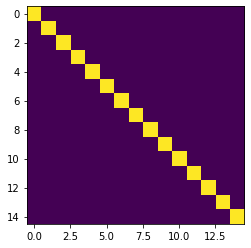

In [10]:
plt.imshow(ideal_fish[1]!)

In [9]:
ideal_fish[1]

array([[8.02955550e+44, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.64755841e+45, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.76920435e+45, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.51962370e+46,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+0

In [ ]:
# Create Fisher matrix
t_init = time.time()
ideal_fish = tspec.compute_fisher_ideal('both',True,16) 

# IDEAL FISHER
fish_out = '/projects/QUIJOTE/Oliver/polybin_testing/tfish_ideal_%d_%d_%d.npy'%(min_l,dl,Nl)
np.save(fish_out,ideal_fish)

print("Computed ideal Fisher after %d seconds"%(time.time()-t_init))